In [1]:
import numpy as np
import torch, torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms


from tqdm.notebook import tqdm

In [43]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun  7 12:00:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   37C    P8     8W / 250W |  10325MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   44C    P2   162W / 250W |   7192MiB / 11178MiB |     70%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
torchvision.__version__

'0.6.0'

In [6]:
batch_size = 64
n_classes = 10
epochs = 100

chi = 10 # MPS bond dimension

In [4]:
trainset = datasets.MNIST('/files/', download=True, train=True, transform=transforms.ToTensor())
valset = datasets.MNIST('/files/', download=True, train=False, transform=transforms.ToTensor())

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
trainset.data = trainset.data.view(-1, 784)
valset.data = valset.data.view(-1, 784)

XX = trainset.data/255.
X = torch.zeros(XX.size()[0], XX.size()[1], 2)
X[:, :, 0] = XX
X[:, :, 1] = 1 - XX
y = trainset.targets
tensor_trainset = torch.utils.data.TensorDataset(X, y)

XX = valset.data/255.
X = torch.zeros(XX.size()[0], XX.size()[1], 2)
X[:, :, 0] = XX
X[:, :, 1] = 1 - XX
y = valset.targets
tensor_valset = torch.utils.data.TensorDataset(X, y)

num_workers = 3

train_dataloader = torch.utils.data.DataLoader(
    tensor_trainset, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(
    tensor_valset, batch_size=batch_size,
    num_workers=num_workers, shuffle=False, pin_memory=True)

print(f"Train/val dataloaders have {len(train_dataloader)} and {len(val_dataloader)} batches")

Train/val dataloaders have 938 and 157 batches


In [8]:
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 784, 2])
torch.Size([64])


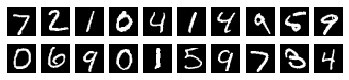

In [10]:
figure = plt.figure()
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index - 1][:, 1].numpy().squeeze().reshape(28, 28), cmap='gray_r')

In [20]:
def set_learning_rate(optimizer, new_learning_rate):
    """Set learning rates of the optimizer to `new_learning_rate`."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_learning_rate
        
def validate(model, dataloader):
    """Compute accuracy on the `dataloader` dataset."""
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(DEVICE)
            probabilities = model(images.to(DEVICE))
            predictions = probabilities.max(1)[1]

            total += len(labels)
            correct += (predictions == labels).sum().item()
            
    return correct / total

In [21]:
n_sites = 784
torch.manual_seed(0)

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
images, labels= images.to(DEVICE), labels.to(DEVICE)


## MPS without isometries

In [22]:
class MPSLayer(torch.nn.Module):
  def __init__(self, n_sites, chi, n_output):
    super(MPSLayer, self).__init__()
    if n_sites % 2:
      raise NotImplementedError("Number of sites should be even but is "
                                  "{}.".format(n_sites))
    self.n_half = n_sites // 2
    self.left = nn.Parameter(self._initializer(self.n_half, 2, chi))
    self.right = nn.Parameter(self._initializer(self.n_half, 2, chi))
    self.middle = nn.Parameter(self._initializer(n_output, 1, chi)[0])

  @staticmethod
  def _initializer(n_sites, d_phys, chi):
    w = torch.stack(d_phys * n_sites * (torch.eye(chi),))
    w = w.view(d_phys, n_sites, chi, chi)
    return w + torch.empty(d_phys, n_sites, chi, chi).normal_(mean=0,std=1e-2)

  @staticmethod
  def reduction(tensor):
    length = tensor.size()[0]
    while length > 1:
      half_length = length // 2
      nice_length = 2*half_length
      leftover = tensor[nice_length:]
      tensor = torch.matmul(tensor[0:nice_length:2], tensor[1:nice_length:2])
      tensor = torch.cat((tensor, leftover), axis=0)
      length = half_length + int(length % 2 == 1)
    return tensor[0]  

  def forward(self, inputs):
    left = torch.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])
    right = torch.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])
    left = self.reduction(left)
    right = self.reduction(right)
    return torch.einsum("bij,cjk,bki->bc", left, self.middle, right)        

In [28]:
model = nn.Sequential(
    MPSLayer(n_sites, chi, n_classes),
    nn.LogSoftmax(dim=1)
)

model.to(DEVICE);

In [29]:
trainable_parameters = model.parameters()
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 3e-4
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

In [30]:
def train(model, dataloader, criterion, optimizer):
    """Train for one epoch, return accuracy and average loss."""
    model.train()

    correct, total = 0, 0
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        probabilities = model(images.to(DEVICE))

        with torch.no_grad():
            labels = labels.to(DEVICE)
            predictions = probabilities.max(1)[1]
            
            total += len(labels)
            correct += (predictions == labels).sum().item()

        loss_value = criterion(probabilities, labels)
        total_loss += loss_value.item() * len(labels)
        
        optimizer.zero_grad()
       

        loss_value.backward()
        optimizer.step()
    return correct / total, total_loss / total

In [31]:
epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [32]:
for _ in range(5):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (8, 13, 16):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

# Compute final validation accuracy
val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

After 0 epochs, training accuracy: nan% (loss nan), validation accuracy: 8.97%



After 1 epochs, training accuracy: 90.94% (loss 0.2983), validation accuracy: 95.78%



After 2 epochs, training accuracy: 95.99% (loss 0.1409), validation accuracy: 96.05%



After 3 epochs, training accuracy: 96.68% (loss 0.1146), validation accuracy: 96.70%



After 4 epochs, training accuracy: 97.00% (loss 0.1062), validation accuracy: 96.61%



After 5 epochs, training accuracy: 97.26% (loss 0.0981), validation accuracy: 97.60%


## MPS with isometries

In [36]:
class IsoMPSLayer(torch.nn.Module):
  def __init__(self, n_sites, chi, n_output):
    super(IsoMPSLayer, self).__init__()
    if n_sites % 2:
      raise NotImplementedError("Number of sites should be even but is "
                                  "{}.".format(n_sites))
    self.n_half = n_sites // 2
    self.left = nn.Parameter(self._initializer(self.n_half, 2, chi))
    self.right = nn.Parameter(self._initializer(self.n_half, 2, chi))
    self.middle = nn.Parameter(self._initializer(n_output, 1, chi)[0])

  @staticmethod
  def _initializer(n_sites, d_phys, chi):
    w = torch.stack(d_phys * n_sites * (torch.eye(chi),))
    w = w.view(d_phys, n_sites, chi, chi)
    #return w + torch.empty(d_phys, n_sites, chi, chi).normal_(mean=0,std=1e-2)
    w = w.permute(1, 0, 2, 3)
    w = w.reshape(n_sites, d_phys*chi, chi)
    U, D, V = torch.svd(w)
    # Ids = torch.stack(D.shape[0]*(torch.eye(D.shape[1]), ))
    # pr = torch.einsum('nij, njk, nlk -> nil', U, Ids, V)
    # pr = pr.reshape(n_sites, d_phys, chi, chi)
    # pr = pr.permute(1, 0, 2, 3) #+ torch.empty(d_phys, n_sites, chi, chi).normal_(mean=0,std=1e-2)
    # return pr
    # q, _ = torch.qr(torch.empty(n_sites, d_phys*chi, chi).normal_(mean=0,std=1))
    # q = q.reshape(n_sites, d_phys, chi, chi)
    # q = q.permute(1, 0, 2, 3)
    # return q #+ torch.empty(d_phys, n_sites, chi, chi).normal_(mean=0,std=1e-3)

  @staticmethod
  def reduction(tensor):
    length = tensor.size()[0]
    while length > 1:
      half_length = length // 2
      nice_length = 2*half_length
      leftover = tensor[nice_length:]
      tensor = torch.matmul(tensor[0:nice_length:2], tensor[1:nice_length:2])
      tensor = torch.cat((tensor, leftover), axis=0)
      length = half_length + int(length % 2 == 1)
    return tensor[0]  

  def forward(self, inputs):
    left = torch.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half])
    right = torch.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:])
    left = self.reduction(left)
    right = self.reduction(right)
    return torch.einsum("bij,cjk,bki->bc", left, self.middle, right)

In [37]:
model = nn.Sequential(
    IsoMPSLayer(n_sites, chi, n_classes),
    nn.LogSoftmax(dim=1)
)

model.to(DEVICE);

In [38]:
trainable_parameters = model.parameters()
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 3e-4
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

In [39]:
def train(model, dataloader, criterion, optimizer):
    """Train for one epoch, return accuracy and average loss."""
    model.train()

    correct, total = 0, 0
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        probabilities = model(images.to(DEVICE))

        with torch.no_grad():
            labels = labels.to(DEVICE)
            predictions = probabilities.max(1)[1]
            
            total += len(labels)
            correct += (predictions == labels).sum().item()

        loss_value = criterion(probabilities, labels)
        total_loss += loss_value.item() * len(labels)
        
        optimizer.zero_grad()
       

        loss_value.backward()
        optimizer.step()
        with torch.no_grad():
          ls = model[0].left.size()
          # # test = torch.zeros(ls).to(DEVICE)
          # # test[0, :, :, :] = torch.stack(ls[1]*(torch.eye(ls[2]),))
          # # test[1, :, :, :] = torch.stack(ls[1]*(torch.eye(ls[2]),))
          # model[0].left[0] = torch.mul(model[0].left[0],  torch.stack(ls[1]*(torch.eye(ls[2]),)).to(DEVICE) )
          # model[0].left[1] = torch.mul(model[0].left[0],  torch.stack(ls[1]*(torch.eye(ls[2]),)).to(DEVICE) )
          # model[0].right[0] = torch.mul(model[0].left[0],  torch.stack(ls[1]*(torch.eye(ls[2]),)).to(DEVICE) )
          # #model[0].right[1] = torch.mul(model[0].left[0],  torch.stack(ls[1]*(torch.eye(ls[2]),)).to(DEVICE) )
    return correct / total, total_loss / total

In [40]:
epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [44]:
for _ in range(3):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (8, 13, 16):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

# Compute final validation accuracy
val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

After 6 epochs, training accuracy: 97.55% (loss 0.0914), validation accuracy: 97.56%



After 7 epochs, training accuracy: 97.68% (loss 0.0817), validation accuracy: 97.00%



Decreasing the learning rate to 2.9999999999999997e-05
After 8 epochs, training accuracy: 97.92% (loss 0.0763), validation accuracy: 97.40%



After 9 epochs, training accuracy: 99.11% (loss 0.0295), validation accuracy: 98.35%
